<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/GAMs/GAM_NAM_models_comparison_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================================================================
# GAM & NAM for Diabetes Classification — Full Metrics + Plots
# ---------------------------------------------------------------
# What this cell does:
# 1) Build/train a GAM-like model (SplineTransformer + LogisticRegression)
# 2) Build/train a simple Neural Additive Model (NAM) in PyTorch (if available)
# 3) Compute TRAIN and TEST metrics (AUC, Accuracy, Precision, Recall, F1) for both models
# 4) Show a single combined metrics table for GAM & NAM (train + test)
# 5) Plot ROC curves: two subplots (GAM | NAM); each shows Train and Test curves with legend
# 6) Plot confusion matrices: 2x2 grid (GAM train/test on top; NAM train/test on bottom)
# 7) Save figures (PNG+PDF) and metrics table (CSV)
# ================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, confusion_matrix
)

import pandas as pd

# Load the dataset (make sure the file is in your working directory)
df = pd.read_csv("diabetes.csv")

# Define features and target
feature_names = [col for col in df.columns if col != "Outcome"]

df.shape
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,PedigreeFun,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**1. Correlation Heatmap (Pearson / Spearman) Pearson: linear correlation (default). Spearman: monotonic relationships (robust to outliers).**

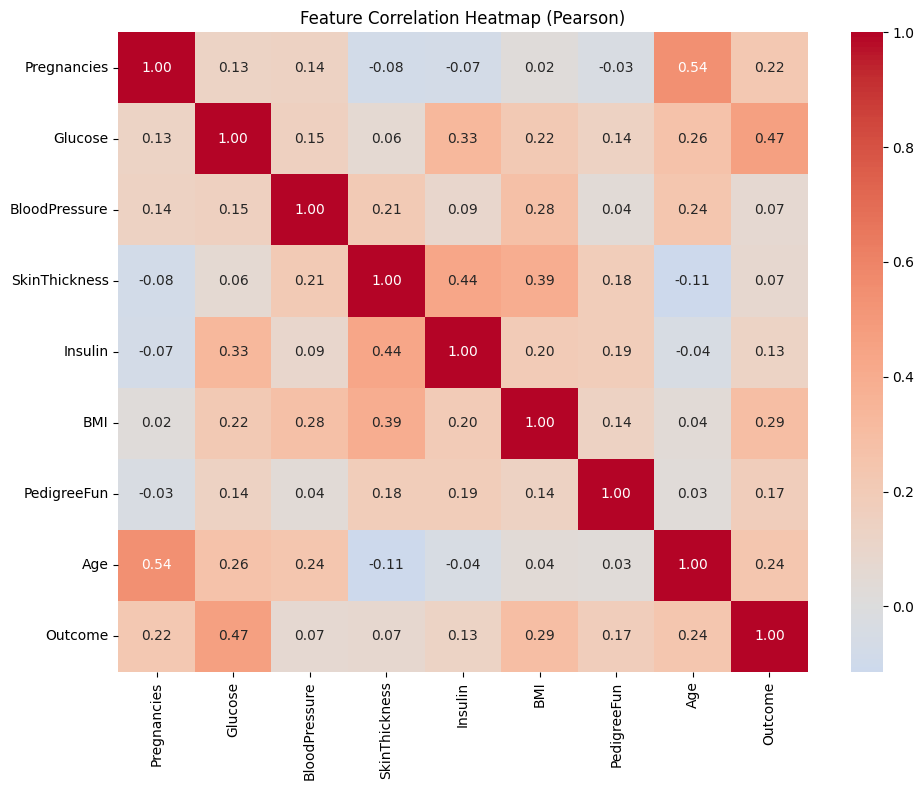

Saved -> feature_correlation_heatmap_pearson.png


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Pearson correlations between all numeric features
corr = df[feature_names + ["Outcome"]].corr(method="pearson")

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f", ax=ax)
ax.set_title("Feature Correlation Heatmap (Pearson)")

fig.tight_layout()
fig.savefig("feature_correlation_heatmap_pearson.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved -> feature_correlation_heatmap_pearson.png")



**2. Feature vs. Target Correlation (sorted bar plot) Which features correlate most with diabetes (Outcome)?**

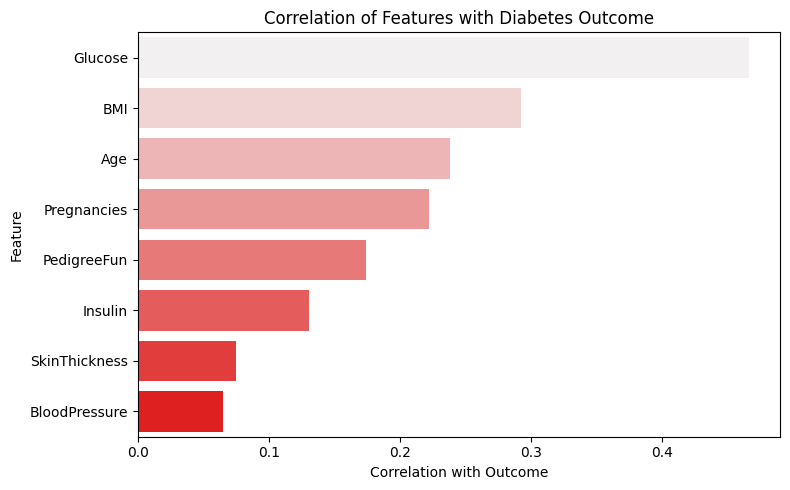

In [ ]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

target_corr = df.corr(numeric_only=True)["Outcome"].drop("Outcome").sort_values(ascending=False)
corr_df = target_corr.reset_index().rename(columns={"index":"Feature", "Outcome":"Correlation"})

# a nice brown gradient (SaddleBrown base)
palette_list = sns.light_palette("Red", n_colors=len(corr_df), reverse=False)

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=corr_df,
    x="Correlation",
    y="Feature",
    hue="Feature",                   # use y as hue
    hue_order=corr_df["Feature"],    # keep order consistent
    palette=palette_list,
    dodge=False,
    legend=False,
    ax=ax
)
ax.set_title("Correlation of Features with Diabetes Outcome")
ax.set_xlabel("Correlation with Outcome")
fig.tight_layout()
fig.savefig("Correlation_with_Outcomes.png", dpi=200, bbox_inches="tight")
plt.show()


**3. Pairwise Scatterplots (Outcome-colored) Helps visualize nonlinear relationships.**

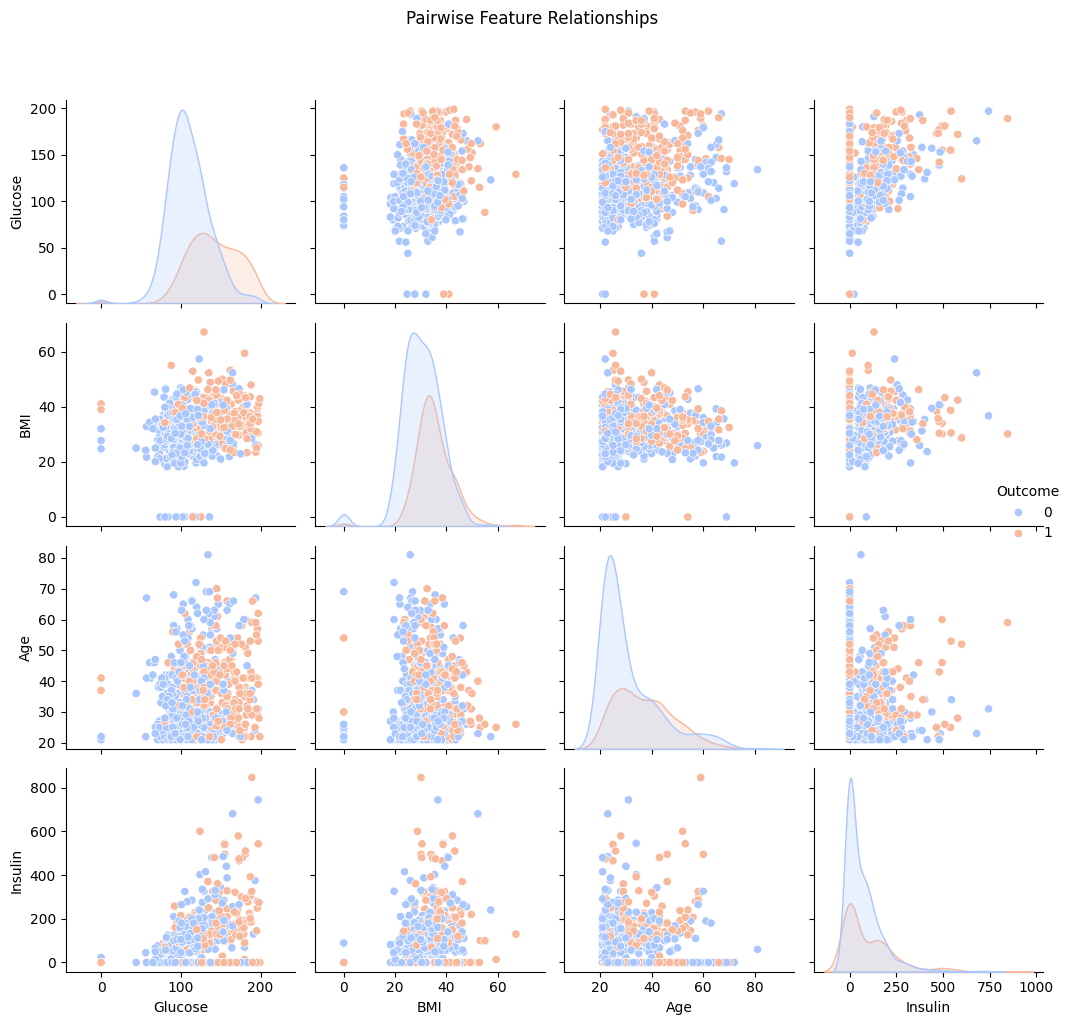

Saved -> pairwise_feature_relationships.png


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.pairplot(
    df,
    vars=["Glucose", "BMI", "Age", "Insulin"],
    hue="Outcome",
    diag_kind="kde",
    palette="coolwarm"
)

# Title + spacing
g.fig.suptitle("Pairwise Feature Relationships", y=1.02)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.93)  # keep the title visible

# Save then show
out_png = "pairwise_feature_relationships.png"
g.fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.show()

print("Saved ->", out_png)



**4. Distribution Comparisons by Outcome: Boxplots / violinplots-show differences between diabetics vs. non-diabetics.**

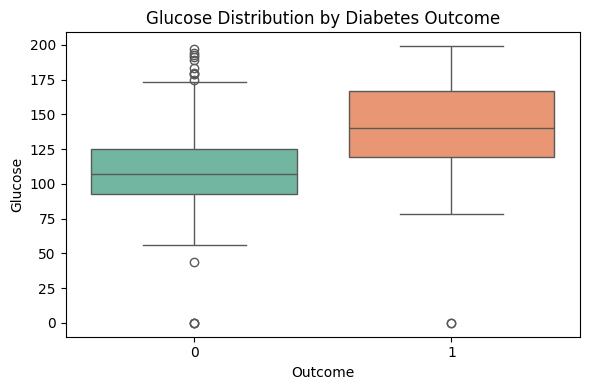

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(
    data=df,
    x="Outcome",
    y="Glucose",
    hue="Outcome",          # <-- add hue when using palette
    palette="Set2",
    dodge=False,            # no side-by-side duplication since hue==x
    legend=False,           # hide redundant legend
    ax=ax,
)
ax.set_title("Glucose Distribution by Diabetes Outcome")
ax.set_xlabel("Outcome")
ax.set_ylabel("Glucose")

fig.tight_layout()
fig.savefig("Glucose_Distribution_by_Diabetes_Outcome.png", dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
# ---------------------------
# 0) Setup & checks
# ---------------------------
RANDOM_STATE = 42
FIG_DIR = "figures"
TAB_DIR = "tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

assert 'df' in globals(), "You must define a DataFrame `df`."
assert 'feature_names' in globals(), "You must define a list `feature_names` of predictors."
assert 'Outcome' in df.columns, "Your df must have a binary target column named 'Outcome'."

# Split (Train/Val/Test if you want; here we use just Train/Test metrics per request)
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["Outcome"], random_state=RANDOM_STATE
)
X_train = train_df[feature_names].copy()
y_train = train_df["Outcome"].astype(int).copy()
X_test  = test_df[feature_names].copy()
y_test  = test_df["Outcome"].astype(int).copy()

# ---------------------------
# 1) Build & train GAM-like model
# ---------------------------
def build_gam_pipeline(features, n_splines=12, degree=3, C=1.0, max_iter=2000):
    """GAM-like pipeline: per-feature SplineTransformer + LogisticRegression."""
    per_feature = []
    for f in features:
        per_feature.append((f, SplineTransformer(degree=degree, n_knots=n_splines, include_bias=False), [f]))
    col_transformer = ('splines',  # name
                       None,       # placeholder (we'll build ColumnTransformer implicitly via FeatureUnion-like pattern)
                       features)   # only for clarity; not directly used here

    # We can do a single SplineTransformer that acts on all columns with 'feature_names' order
    # but to keep control, we stack per-feature transforms then Standardize and fit LR.
    # Practical approach: single SplineTransformer with 'n_knots' for each numeric column.
    # Here we just use a single SplineTransformer that takes all columns.
    pipe = Pipeline([
        ('spline', SplineTransformer(degree=degree, n_knots=n_splines, include_bias=False)),
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False for sparse/expanded bases
        ('clf', LogisticRegression(C=C, max_iter=max_iter, solver='lbfgs'))
    ])
    return pipe

gam_pipe = build_gam_pipeline(feature_names, n_splines=12, degree=3, C=1.0)
gam_pipe.fit(X_train.values, y_train.values)

# Predictions (probs) for Train & Test
y_gam_train_proba = gam_pipe.predict_proba(X_train.values)[:, 1]
y_gam_test_proba  = gam_pipe.predict_proba(X_test.values)[:, 1]
y_gam_train_pred  = (y_gam_train_proba >= 0.5).astype(int)
y_gam_test_pred   = (y_gam_test_proba  >= 0.5).astype(int)

# ---------------------------
# 2) Build & train NAM (PyTorch) — optional if torch is available
# ---------------------------
TORCH_AVAILABLE = False
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

class PerFeatureNet(nn.Module):
    """Simple 1D MLP for a single feature."""
    def __init__(self, hidden_layers=[32,16], activation=nn.ReLU):
        super().__init__()
        layers = []
        in_dim = 1
        for h in hidden_layers:
            layers += [nn.Linear(in_dim, h), activation()]
            in_dim = h
        layers += [nn.Linear(in_dim, 1)]  # output contribution for this feature
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)  # shape: (batch,1)

class NAM(nn.Module):
    """Sum of per-feature subnets + bias -> sigmoid."""
    def __init__(self, n_features, hidden_layers=[32,16], activation=nn.ReLU):
        super().__init__()
        self.n_features = n_features
        self.subnets = nn.ModuleList([PerFeatureNet(hidden_layers, activation) for _ in range(n_features)])
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        # x: (batch, n_features)
        outs = [self.subnets[i](x[:, i:i+1]) for i in range(self.n_features)]
        total = torch.sum(torch.cat(outs, dim=1), dim=1, keepdim=True) + self.bias
        return torch.sigmoid(total).squeeze(1)

def train_nam(model, Xtr, ytr, Xva=None, yva=None, epochs=60, lr=1e-3, batch_size=64, device='cpu'):
    Xtr_t = torch.tensor(Xtr.values, dtype=torch.float32)
    ytr_t = torch.tensor(ytr.values, dtype=torch.float32)
    tr_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch_size, shuffle=True)

    if Xva is not None and yva is not None:
        Xva_t = torch.tensor(Xva.values, dtype=torch.float32)
        yva_t = torch.tensor(yva.values, dtype=torch.float32)
        va_loader = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=batch_size, shuffle=False)
    else:
        va_loader = None

    model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCELoss()

    model.train()
    for _ in range(epochs):
        for xb, yb in tr_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            preds = model(xb)
            loss = bce(preds, yb)
            loss.backward()
            opt.step()
    return model

# Prepare scaled features for NAM (helps training stability)
scaler_nam = StandardScaler()
X_train_n = pd.DataFrame(scaler_nam.fit_transform(X_train), columns=feature_names, index=X_train.index)
X_test_n  = pd.DataFrame(scaler_nam.transform(X_test), columns=feature_names, index=X_test.index)

if TORCH_AVAILABLE:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    nam = NAM(n_features=len(feature_names), hidden_layers=[32,16])
    nam = train_nam(nam, X_train_n, y_train, epochs=80, lr=1e-3, device=device)

    nam.eval()
    with torch.no_grad():
        Xtr_t = torch.tensor(X_train_n.values, dtype=torch.float32).to(device)
        Xte_t = torch.tensor(X_test_n.values,  dtype=torch.float32).to(device)
        y_nam_train_proba = nam(Xtr_t).detach().cpu().numpy()
        y_nam_test_proba  = nam(Xte_t).detach().cpu().numpy()
    y_nam_train_pred = (y_nam_train_proba >= 0.5).astype(int)
    y_nam_test_pred  = (y_nam_test_proba  >= 0.5).astype(int)
else:
    # Fallback: no NAM; fill with NaNs so table still renders
    y_nam_train_proba = np.full_like(y_gam_train_proba, np.nan, dtype=float)
    y_nam_test_proba  = np.full_like(y_gam_test_proba,  np.nan, dtype=float)
    y_nam_train_pred  = np.full_like(y_gam_train_pred,  np.nan, dtype=float)
    y_nam_test_pred   = np.full_like(y_gam_test_pred,   np.nan, dtype=float)

# ---------------------------
# 3) Metrics helpers
# ---------------------------
def binary_metrics(y_true, y_proba, y_pred):
    """Return dict of AUC/Acc/Prec/Rec/F1; handles NaNs if proba/pred unavailable."""
    out = {}
    out['AUC']       = roc_auc_score(y_true, y_proba) if np.isfinite(y_proba).all() else np.nan
    out['Accuracy']  = accuracy_score(y_true, y_pred) if np.isfinite(y_pred).all()  else np.nan
    out['Precision'] = precision_score(y_true, y_pred, zero_division=0) if np.isfinite(y_pred).all() else np.nan
    out['Recall']    = recall_score(y_true, y_pred, zero_division=0)    if np.isfinite(y_pred).all() else np.nan
    out['F1']        = f1_score(y_true, y_pred, zero_division=0)        if np.isfinite(y_pred).all() else np.nan
    return out

# Compute metrics for the four cases
rows = []
rows.append(('GAM','Train', binary_metrics(y_train, y_gam_train_proba, y_gam_train_pred)))
rows.append(('GAM','Test',  binary_metrics(y_test,  y_gam_test_proba,  y_gam_test_pred )))
rows.append(('NAM','Train', binary_metrics(y_train, y_nam_train_proba, y_nam_train_pred)))
rows.append(('NAM','Test',  binary_metrics(y_test,  y_nam_test_proba,  y_nam_test_pred )))

metrics_df = pd.DataFrame(
    [r[2] for r in rows],
    index=pd.MultiIndex.from_tuples([(r[0], r[1]) for r in rows], names=['Model','Split'])
).loc[:, ['AUC','Accuracy','Precision','Recall','F1']]

display(metrics_df)
metrics_df.to_csv(os.path.join(TAB_DIR, "metrics_gam_nam_train_test.csv"))


AUC  Accuracy  Precision    Recall        F1
Model Split                                                   
GAM   Train  0.913248  0.837134   0.803191  0.705607  0.751244
      Test   0.801667  0.733766   0.614035  0.648148  0.630631
NAM   Train  0.879171  0.802932   0.759777  0.635514  0.692112
      Test   0.823889  0.740260   0.645833  0.574074  0.607843

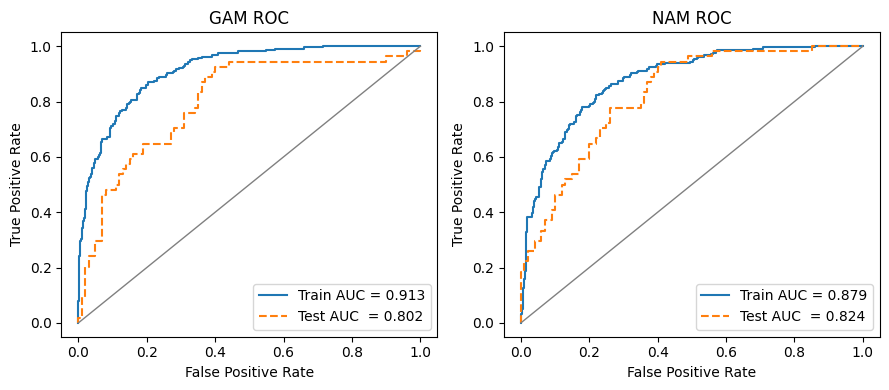

In [ ]:
# ---------------------------
# 4) ROC plots (two subplots: left=GAM, right=NAM; each has Train & Test)
# ---------------------------
def plot_roc_subplot(ax, y_true_train, proba_train, y_true_test, proba_test, title):
    # Train
    fpr_tr, tpr_tr, _ = roc_curve(y_true_train, proba_train)
    ax.plot(fpr_tr, tpr_tr, label=f"Train AUC = {roc_auc_score(y_true_train, proba_train):.3f}")
    # Test
    fpr_te, tpr_te, _ = roc_curve(y_true_test,  proba_test)
    ax.plot(fpr_te, tpr_te, linestyle='--', label=f"Test AUC  = {roc_auc_score(y_true_test,  proba_test):.3f}")
    # Diagonal
    ax.plot([0,1],[0,1], color='gray', linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc='lower right')

fig, axes = plt.subplots(1, 2, figsize=(9,4))
plot_roc_subplot(axes[0], y_train, y_gam_train_proba, y_test, y_gam_test_proba, "GAM ROC")
if np.isfinite(y_nam_train_proba).all() and np.isfinite(y_nam_test_proba).all():
    plot_roc_subplot(axes[1], y_train, y_nam_train_proba, y_test, y_nam_test_proba, "NAM ROC")
else:
    axes[1].set_title("NAM ROC (PyTorch not available)")
    axes[1].axis('off')
plt.tight_layout()
fig_path = os.path.join("roc_gam_nam.png")
plt.savefig(fig_path, bbox_inches='tight', dpi=150)
plt.show()


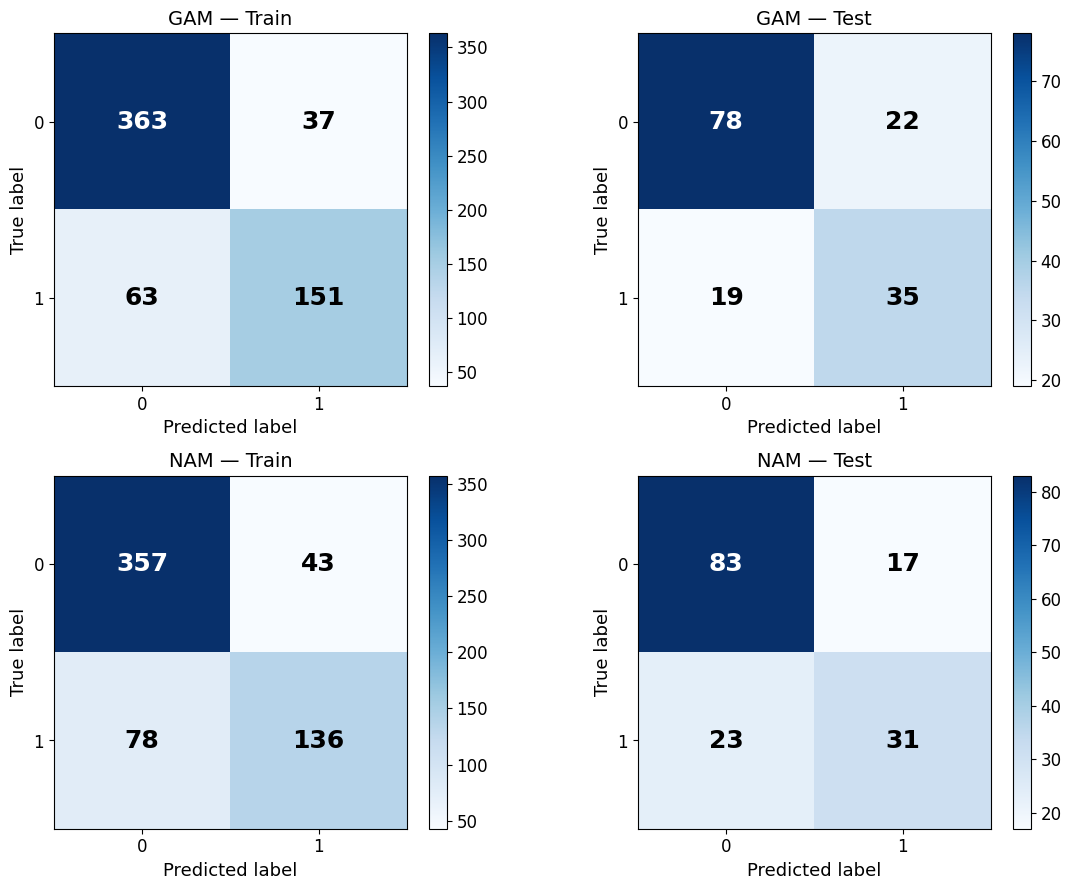

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

chosen_cmap = "Blues"   # pick any cmap: "magma", "viridis", "plasma", "copper", "Blues", ...

def plot_cm(ax, y_true, y_pred, title, cmap=chosen_cmap,
            annot_fs=18, title_fs=14, label_fs=13, tick_fs=12, show_colorbar=True):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    if show_colorbar:
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=tick_fs)

    ax.set_title(title, fontsize=title_fs)
    ax.set_xlabel("Predicted label", fontsize=label_fs)
    ax.set_ylabel("True label", fontsize=label_fs)
    ax.set_xticks([0,1]); ax.set_xticklabels(['0','1'], fontsize=tick_fs)
    ax.set_yticks([0,1]); ax.set_yticklabels(['0','1'], fontsize=tick_fs)

    # annotate counts with dynamic text color for contrast
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.0
    for i in range(2):
        for j in range(2):
            color = "white" if cm[i, j] > thresh else "black"
            ax.text(j, i, int(cm[i, j]),
                    ha="center", va="center",
                    fontsize=annot_fs, color=color, fontweight="bold")

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

plot_cm(axes[0,0], y_train, y_gam_train_pred, "GAM — Train")
plot_cm(axes[0,1], y_test,  y_gam_test_pred,  "GAM — Test")

if np.isfinite(y_nam_train_pred).all() and np.isfinite(y_nam_test_pred).all():
    plot_cm(axes[1,0], y_train, y_nam_train_pred, "NAM — Train")
    plot_cm(axes[1,1], y_test,  y_nam_test_pred,  "NAM — Test")
else:
    axes[1,0].set_title("NAM — Train (N/A)", fontsize=13, fontweight="bold")
    axes[1,0].axis('off')
    axes[1,1].set_title("NAM — Test (N/A)", fontsize=13, fontweight="bold")
    axes[1,1].axis('off')

plt.tight_layout()
cm_png = "confusion_matrices_gam_nam.png"
plt.savefig(cm_png, bbox_inches='tight', dpi=200)
plt.show()
